In [0]:
# Load libraries

#import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# Load dataset
from google.colab import drive
drive.mount('/content/gdrive')

filename = 'df_highway_2012_4mon_sample.h5'

df_LA = pd.read_hdf('/content/gdrive/My Drive/NNDL-data/' + filename)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#fdr_tt['measurement_tstamp'] = pd.to_datetime(fdr_tt['measurement_tstamp'])
df_LA.dtypes
df_LA.shape


(34272, 207)

In [48]:
# Choosing a subset of the sensors 
# due to lack of computational resources for ConvLSTM
sens_sub = pd.read_csv('/content/gdrive/My Drive/NNDL-data/sensor-adj.csv')

spd_mat = np.zeros([df_LA.shape[0],sens_sub.shape[0]])
for i in range(sens_sub.shape[0]):
  spd_mat[:,i] = np.array(df_LA[sens_sub.iloc[i]['sensor_id'].astype(int).astype(str)])

print(spd_mat.shape)

n_out = spd_mat.shape[-1]

(34272, 7)


## Visualization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8e7f56ef0>,
      dtype=object)

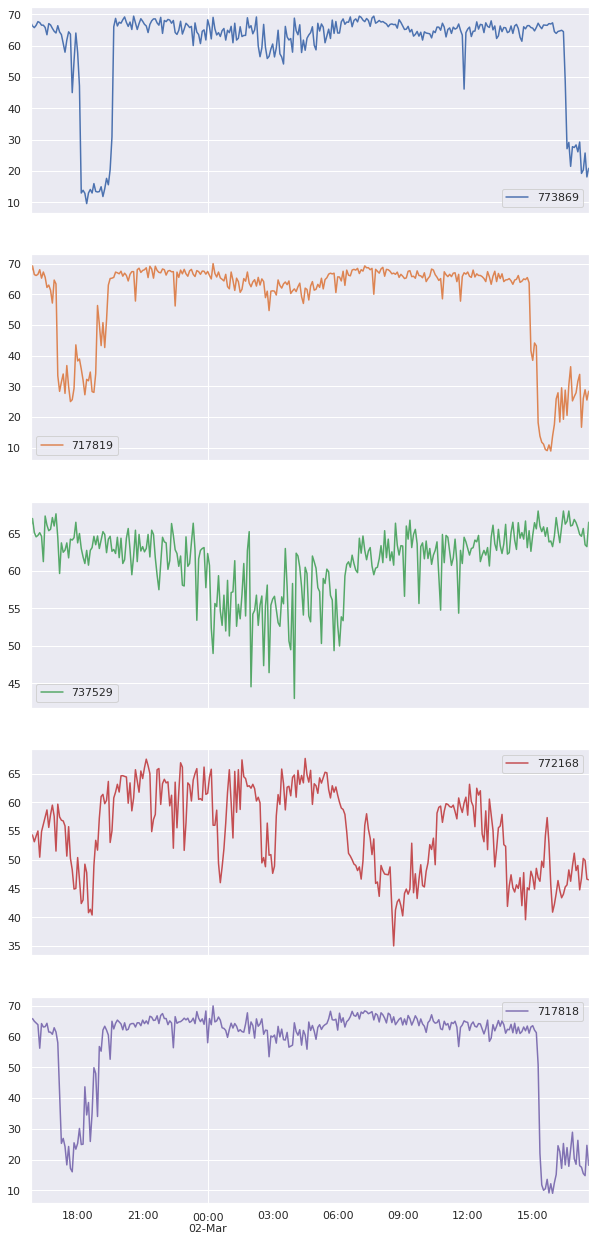

In [0]:
# Multi-series plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 4)})

fig, axes = plt.subplots(5,1, figsize=(10,22), sharex=True)
df_LA.iloc[190:500][['773869', '717819','737529','772168','717818']].plot(subplots=True, ax=axes)

<Figure size 432x288 with 0 Axes>

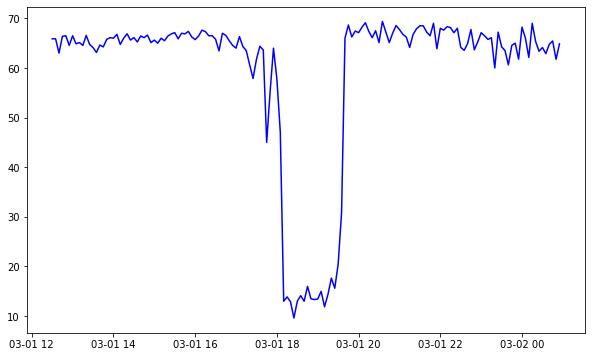

In [0]:
plt.figure()
plt.figure(figsize=(10,6))

link = 96
plt.plot(df_LA.iloc[150:300][['773869']], 'b')


plt.show()

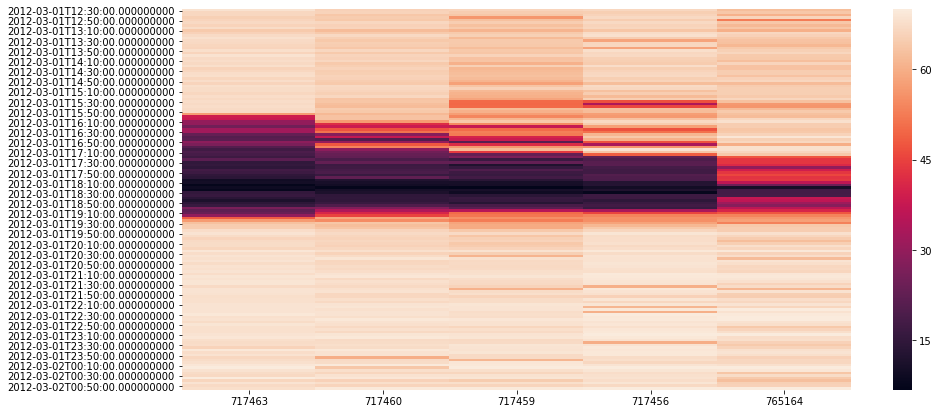

In [0]:
# Heat map
import seaborn as sns
plt.rcParams['figure.figsize'] = (15.0, 7.0)
#plt.rcParams['font.family'] = "serif"

sns.heatmap(df_LA.iloc[150:300][['717463', '717460','717459','717456','765164']])

In [0]:
717463
717460
717459
717456
765164

<Figure size 432x288 with 0 Axes>

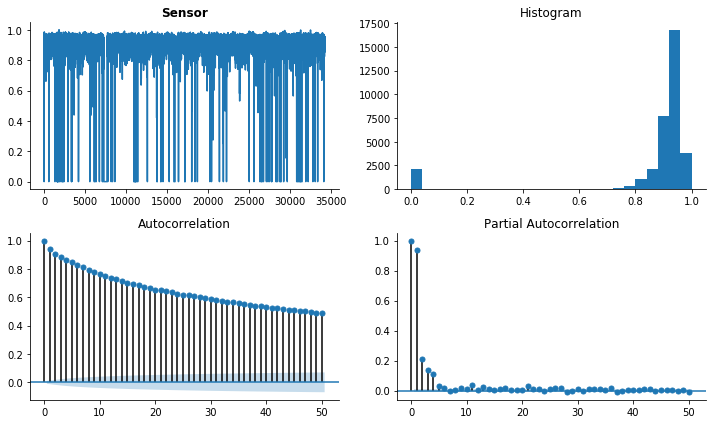

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3a15fd6f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a15f2e198>)

In [0]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()

def tsplot_np(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    hist_ax.hist(y, bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax


tsplot_np(spd_mat[:,1],'Sensor',50)

## Data Generators

### Data Normalization

In [0]:

#spd_mat = df_LA.to_numpy()

#print(spd_mat.shape)

spd_scaler = MinMaxScaler(feature_range=(0, 1))
spd_mat = spd_scaler.fit_transform(spd_mat)

#spd_std_scaler = StandardScaler(with_mean=True, with_std=True)
#spd_mat = spd_std_scaler.fit_transform(spd_mat)

n_out = spd_mat.shape[-1]


### Generator functions

In [0]:

# This generator function is modified from Chollet (2018), Deep Learning with Python

def generator_mat(data, lag, ahead, min_ind, max_ind, shuffle=False, batch_size=128, step=1):
    if max_ind is None:
        max_ind = len(data) - ahead - 1
    i = min_ind + lag
    while 1:
        if shuffle:
            rows = np.random.randint(min_ind+lag, max_ind, size=batch_size)
        else:
            if i+batch_size >= max_ind:
                i=min_ind+lag
            rows = np.arange(i,min(i+batch_size, max_ind))
            i += len(rows)
        
        # change to following for multivar (>1 columns)
        samples = np.zeros((len(rows),lag//step, data.shape[-1]))
        targets = np.zeros((len(rows),data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j]-lag, rows[j], step)
            samples[j]= data[indices]
            targets[j] = data[rows[j] + ahead][:] #index of output vectors
            
        yield samples, targets

In [0]:
# Setting data generation parameters

lag = 3 # lag of 15 minutes
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128



In [0]:
# 119 days total
# 70% -> 83 days for training = 23904 obs
# 20% -> 23 days for valid
# Rest -> test
23*24*12 + 23904

30528

In [0]:
gen_tr = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_val = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_tes = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps = (30528 - 23905 - lag) // batch_size
test_steps = (34272 - 30529 - lag) // batch_size

## Data Generators for Convolutional LSTM

In [0]:
# Building "images" 
#spd_scaler_conv = MinMaxScaler(feature_range=(0, 1))
#spd_mat_conv = spd_scaler_conv.fit_transform(spd_mat_conv)

spd_mat_conv = np.zeros((spd_mat.shape[0],spd_mat.shape[-1],spd_mat.shape[-1]))

for i in range(spd_mat.shape[-1]):
  spd_mat_conv[:,:,i] = spd_mat

spd_mat_conv.shape

# Dimensions of the "image" input to the convolution operator
im_len = 7 # 7 sensor subset data chosen
im_wid = 7

#samp = np.reshape(spd_mat_conv[0:128,:,:],(128, 7,7,1, 1))
#print(samp.shape)



In [0]:
# generator function for ConvLSTM
# Input to ConvLSTM is in the form of 3D tensors i.e., sequence of 2-D "images"
# In this problem the "image" is the sensor data from all sensors at one slice of time

def generator_conv(data, lag, ahead, min_ind, max_ind, shuffle=False, batch_size=128, 
                   step=1):
# im_wid & im_len provide the size of each image
# im_wid x im_len is size of spatial information being encoded into each time step of sequence

    if max_ind is None:
        max_ind = len(data) - ahead - 1
    i = min_ind + lag
    im_wid = data.shape[-1]
    im_len = data.shape[-1]
    while 1:
        if shuffle:
            rows = np.random.randint(min_ind+lag, max_ind, size=batch_size)
        else:
            if i+batch_size >= max_ind:
                i=min_ind+lag
            rows = np.arange(i,min(i+batch_size, max_ind))
            i += len(rows)
        
        samples = np.zeros((len(rows),lag//step, im_len, im_wid, data.shape[-1]))
        targets = np.zeros((len(rows),data.shape[-1]))
        
        for j, row in enumerate(rows):
            
            indices = range(rows[j]-lag, rows[j], step) 
            
            for k in range(data.shape[-1]):
              samples[j,:,:,:,k]= data[indices] 
            targets[j] = data[rows[j] + ahead,:,0] #index of output vectors
#            targets[j] = data[rows[j] + ahead][:][0] #index of output vectors
            
        yield samples, targets

In [53]:
samp = np.zeros((3,lag//step, 7,7, 7))
print(samp[0,:,:,:,0].shape)

(3, 7, 7)


In [0]:
# Setting data generation parameters

lag = 3 # lag of 15 minutes
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128
im_len = 7
im_wid = 7

# Separte generator functions
gen_conv_tr = generator_conv(spd_mat_conv,lag=lag,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_conv_val = generator_conv(spd_mat_conv,lag=lag,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_conv_tes = generator_conv(spd_mat_conv,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps = (30528 - 23905 - lag) // batch_size
test_steps = (34272 - 30529 - lag) // batch_size

In [0]:
import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Convolutional LSTM

In [66]:
# testing ConvLSTM

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(filters=20, kernel_size=(2,2), activation='relu', 
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=RMSprop(), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)
m_conv1 = model
hist_conv1 = history

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, 6, 6, 20)          8720      
_________________________________________________________________
flatten_11 (Flatten)         (None, 720)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 5047      
Total params: 13,767
Trainable params: 13,767
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 11s 22ms/step - loss: 0.1511 - val_loss: 0.1250
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1312 - val_loss: 0.1448
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1258 - val_loss: 0.1240
Epoch 4/40
500/500 [==============================] - 8s 17ms/step - loss: 

In [0]:
m_conv1 = model
hist_conv1 = history

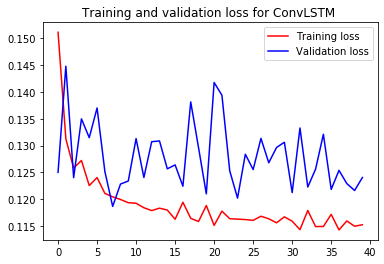

In [67]:
import matplotlib.pyplot as plt

loss = hist_conv1.history['loss']
val_loss = hist_conv1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for ConvLSTM ')
plt.legend()

plt.show()

In [18]:
# ConvLSTM w Adamax + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adamax

model = Sequential()
model.add(layers.ConvLSTM2D(filters=10, kernel_size=(2,2), activation='relu', 
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=Adamax(decay=0.001), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)

m_conv2 = model
hist_conv2 = history


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 6, 6, 10)          2760      
_________________________________________________________________
flatten_2 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 361       
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1369 - val_loss: 0.1485
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1228 - val_loss: 0.1394
Epoch 3/40
500/500 [==============================] - 9s 17ms/step - loss: 0.1194 - val_loss: 0.1336
Epoch 4/40
500/500 [==============================] - 9s 17ms/step - loss: 0.1

In [68]:
# ConvLSTM w 20 filters & RMSprop + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(filters=20, kernel_size=(2,2), activation='relu', 
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)

m_conv3 = model
hist_conv3 = history

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 6, 6, 20)          8720      
_________________________________________________________________
flatten_12 (Flatten)         (None, 720)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 5047      
Total params: 13,767
Trainable params: 13,767
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 11s 21ms/step - loss: 0.1455 - val_loss: 0.1290
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1261 - val_loss: 0.1328
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1225 - val_loss: 0.1379
Epoch 4/40
500/500 [==============================] - 8s 16ms/step - loss: 

In [69]:
# ConvLSTM w 20 filters, 3x3 kernel & RMSprop + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(filters=20, kernel_size=(3,3), activation='relu', 
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)

m_conv4 = model
hist_conv4 = history

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_13 (ConvLSTM2D) (None, 5, 5, 20)          19520     
_________________________________________________________________
flatten_13 (Flatten)         (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 3507      
Total params: 23,027
Trainable params: 23,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 11s 23ms/step - loss: 0.1558 - val_loss: 0.1259
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1269 - val_loss: 0.1376
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1200 - val_loss: 0.1239
Epoch 4/40
500/500 [==============================] - 8s 17ms/step - loss: 

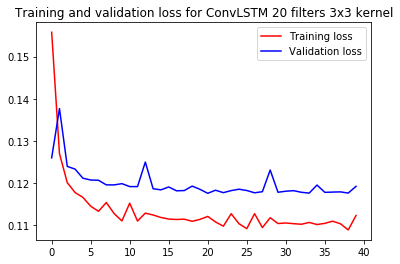

In [71]:
import matplotlib.pyplot as plt

loss = hist_conv4.history['loss']
val_loss = hist_conv4.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for ConvLSTM 20 filters 3x3 kernel')
plt.legend()

plt.show()

In [70]:
# ConvLSTM w 40 filters, 3x3 kernal & RMSprop + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(filters=40, kernel_size=(3,3), activation='relu', 
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)

m_conv5 = model
hist_conv5 = history

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_14 (ConvLSTM2D) (None, 5, 5, 40)          67840     
_________________________________________________________________
flatten_14 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 7007      
Total params: 74,847
Trainable params: 74,847
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 12s 23ms/step - loss: 0.1593 - val_loss: 0.1317
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1288 - val_loss: 0.1538
Epoch 3/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1206 - val_loss: 0.1337
Epoch 4/40
500/500 [==============================] - 8s 17ms/step - loss: 

In [94]:
# ConvLSTM 2 layers w 20 filters, 3x3 kernel & RMSprop + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(filters=20, kernel_size=(3,3), activation='relu', return_sequences=True,
                     input_shape=(None, im_len,im_wid, spd_mat_conv.shape[-1])))
model.add(layers.ConvLSTM2D(filters=20, kernel_size=(3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_out))
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()

history = model.fit_generator(gen_conv_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_conv_val,
                              validation_steps=val_steps)

m_conv4 = model
hist_conv4 = history

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_15 (ConvLSTM2D) (None, None, 5, 5, 20)    19520     
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, 3, 3, 20)          28880     
_________________________________________________________________
flatten_15 (Flatten)         (None, 180)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 1267      
Total params: 49,667
Trainable params: 49,667
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 16s 32ms/step - loss: 0.1614 - val_loss: 0.1402
Epoch 2/40
500/500 [==============================] - 12s 23ms/step - loss: 0.1300 - val_loss: 0.1246
Epoch 3/40
500/500 [=======================

## Baseline Models

In [13]:
# Simple baseline model
def prev_week_val():
    error_mae = []
    error_mse = []
    error_rmse = []
    for step in range(val_steps):
        samples, targets = next(gen_val)
        preds = samples[:,-1,:]
        # univariate
        #preds = samples[:,-1]
        mae = np.mean(np.abs(preds-targets))
        mse = np.mean(np.square(preds-targets))
        rmse = np.sqrt(mse)
        error_mae.append(mae)
        error_mse.append(mse)
        error_rmse.append(rmse)
    
    #print(np.isnan(error_mape).sum)
    print(np.mean(error_mae))
    print(np.mean(error_mse))
    print(np.mean(error_rmse))

prev_week_val()


0.06211793894144958
0.023543097795906964
0.1337625724630841


In [14]:
# Baseline model for Vector Auto-Regression (VAR) time series model

from statsmodels.tsa.vector_ar.var_model import VAR

def eval_var(traffic_reading_df, n_lags=3):
    n_forwards = [1, 3, 6, 12]
    y_predicts, y_test = var_predict(traffic_reading_df, n_forwards = n_forwards,n_lags=n_lags,
                                     test_ratio=0.3)
    for i, horizon in enumerate(n_forwards):
        mae = np.mean(np.abs(y_predicts-y_test))
        mse =  np.mean(np.square(y_predicts-y_test))
        rmse = np.sqrt(mse)
        line = 'VAR\t%d\t%.3f\t%.3f\t%.3f' % (horizon, mae, mse, rmse)
        print(line)
        
def var_predict(df, n_forwards=(1, 3), n_lags=4, test_ratio=0.2):
    """
    Multivariate time series forecasting using Vector Auto-Regressive Model.
    :param df: pandas.DataFrame, index: time, columns: sensor id, content: data.
    :param n_forwards: a tuple of horizons.
    :param n_lags: the order of the VAR model.
    :param test_ratio:
    :return: [list of prediction in different horizon], dt_test
    """
    n_sample, n_output = df.shape
    n_test = int(round(n_sample * test_ratio))
    n_train = n_sample - n_test
    df_train, df_test = df[:n_train], df[n_train:]

    #scaler = StandardScaler(with_mean=True, with_std=True)
    #data = scaler.fit_transform(df_train)
    data = df_train
    var_model = VAR(data)
    var_result = var_model.fit(n_lags)
    max_n_forwards = np.max(n_forwards)
    
    # Do forecasting.
    result = np.zeros(shape=(len(n_forwards), n_test, n_output))
    start = n_train - n_lags - max_n_forwards + 1
    
    for input_ind in range(start, n_sample - n_lags):
#        prediction = var_result.forecast(scaler.transform(df[input_ind: input_ind + n_lags]), max_n_forwards)
        prediction = var_result.forecast(df[input_ind: input_ind + n_lags], max_n_forwards)
        for i, n_forward in enumerate(n_forwards):
            result_ind = input_ind - n_train + n_lags + n_forward - 1
            #print(result_ind)
            if 0 <= result_ind < n_test:
                result[i, result_ind, :] = prediction[n_forward - 1, :]
    
    df_predicts = []
    for i, n_forward in enumerate(n_forwards):
#        df_predicts = scaler.inverse_transform(result[i])
        df_predicts = result[i]
    return df_predicts, df_test
  
eval_var(spd_mat)

VAR	1	0.129	0.050	0.224
VAR	3	0.129	0.050	0.224
VAR	6	0.129	0.050	0.224
VAR	12	0.129	0.050	0.224


## Simpler LSTM Architectures

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.Flatten(input_shape=(lag // step, spd_mat.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_Std_3step_rmse.h5')



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 621)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                19904     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 207)               13455     
Total params: 35,471
Trainable params: 35,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 3s 6ms/step - loss: 0.2111 - val_loss: 0.2088
Epoch 2/40
500/500 [==============================] - 3s 5ms/step - loss: 0.1724 - val_loss: 0.1886
Epoch 3/40
500/500 [============================

In [16]:
# Single layer RNN: GRU 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss=root_mean_squared_error)
m1 = model
history = m1.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
#model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_128_Std_3step_full.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               52224     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 53,127
Trainable params: 53,127
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1359 - val_loss: 0.1405
Epoch 2/40
500/500 [==============================] - 4s 7ms/step - loss: 0.1225 - val_loss: 0.1269
Epoch 3/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1216 - val_loss: 0.1272
Epoch 4/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1172 - val_loss: 0.1233
Epoch 5/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1186 - val_loss: 0.1246
Epoch 6/40
5

In [74]:
# Single layer RNN: LSTM 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss=root_mean_squared_error)
m2 = model
history = m2.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 903       
Total params: 70,535
Trainable params: 70,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 8s 15ms/step - loss: 0.1400 - val_loss: 0.1301
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1254 - val_loss: 0.1314
Epoch 3/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1215 - val_loss: 0.1262
Epoch 4/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1232 - val_loss: 0.1305
Epoch 5/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1191 - val_loss: 0.1295
Epoch 6/40

## Deeper Architecture

In [75]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
m3 = model
history = m3.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_rmse.h5')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 128)         52224     
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 455       
Total params: 89,735
Trainable params: 89,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 9s 18ms/step - loss: 0.1385 - val_loss: 0.1293
Epoch 2/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1225 - val_loss: 0.1273
Epoch 3/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1209 - val_loss: 0.1267
Epoch 4/40
500/500 [==============================] - 5s 11ms/step - loss: 0

## Optimizers

In [0]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units
# RMSProp

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_RMSProp_3step_full.h5')

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_42 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_43 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_39 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 16s 32ms/step - loss: 0.1292 - val_loss: 0.1087
Epoch 2/40
500/500 [==============================] - 7s 13ms/step - loss: 0.1026 - val_loss: 0.1307
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0934 - val_loss: 0.1069
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [0]:

# Stacked GRU Model 
# 2 layer 128/64 units
# SGD w momentum & decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=SGD(momentum=0.9,lr=0.001,decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_SGD_3step_full.h5')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_31 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_33 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 14s 27ms/step - loss: 0.6519 - val_loss: 0.4645
Epoch 2/40
500/500 [==============================] - 7s 13ms/step - loss: 0.3062 - val_loss: 0.1924
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1417 - val_loss: 0.1243
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [0]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adam

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adam(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Adam_3step_full.h5')

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_33 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_34 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 30ms/step - loss: 0.1271 - val_loss: 0.1072
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0962 - val_loss: 0.0949
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0898 - val_loss: 0.0948
Epoch 4/40
500/500 [==============================] - 7s 14ms/step - loss

In [0]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adam + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adam(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_AdamDecay_3step_full.h5')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_35 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_35 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 30ms/step - loss: 0.1293 - val_loss: 0.1092
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0931 - val_loss: 0.0975
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0930 - val_loss: 0.0946
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [0]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adamax

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adamax

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adamax(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Adamax_3step_full.h5')

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_37 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_36 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 31ms/step - loss: 0.1220 - val_loss: 0.1077
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0965 - val_loss: 0.0920
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0899 - val_loss: 0.0943
Epoch 4/40
500/500 [==============================] - 7s 13ms/step - loss

## Comparing Prediciton

In [0]:
#

In [0]:

test_pred_conv1 = m_conv3.predict_generator(gen_conv_tes, steps=test_steps)
test_pred_conv2 = m_conv4.predict_generator(gen_conv_tes, steps=test_steps)

test_pred1 = m2.predict_generator(gen_tes, steps=test_steps)
test_pred2 = m3.predict_generator(gen_tes, steps=test_steps)



In [0]:

abs_err0 = np.absolute(test_pred_conv1, spd_mat[30529:30529+3712,])
mean_abs_err0 = np.mean(abs_err0,axis=0)
#print(mean_abs_err1.shape)
#print(np.var(abs_err1,axis=1))

abs_err1 = np.absolute(test_pred1, spd_mat[30529:30529+3712,])
mean_abs_err1 = np.mean(abs_err1,axis=0)

abs_err2 = np.absolute(test_pred2, spd_mat[30529:30529+3712,])
mean_abs_err2 = np.mean(abs_err2,axis=0)

abs_err3 = np.absolute(test_pred_conv2, spd_mat[30529:30529+3712,])
mean_abs_err3 = np.mean(abs_err3,axis=0)

#abs_err4 = np.absolute(test_pred4, spd_mat[30529:30529+3584,])
#mean_abs_err4 = np.mean(abs_err4,axis=0)


In [0]:
print(mean_abs_err0.shape)

(207,)


<Figure size 432x288 with 0 Axes>

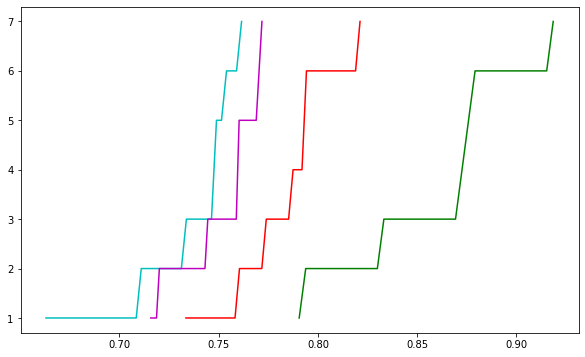

In [78]:
import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.figure(figsize=(10,6))

values, base = np.histogram(mean_abs_err0, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='g', label='FFMLP')

values, base = np.histogram(mean_abs_err1, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='c', label='GRU 1 Layer')

values, base = np.histogram(mean_abs_err2, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='m', label='GRU 2 Layer')

values, base = np.histogram(mean_abs_err3, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='r', label='GRU 2 Layer 12 lag')

#values, base = np.histogram(mean_abs_err4, bins=40)
#cumulative = np.cumsum(values)
#plt.plot(base[:-1], cumulative, c='b', label='GRU 2 Layer 64 lag')



plt.show()

In [51]:
test_pred1.shape

(3712, 7)

In [0]:
# Rescale test & data
test_ups_pred0 = spd_scaler.inverse_transform(test_pred_conv1)
test_ups_pred1 = spd_scaler.inverse_transform(test_pred1)
test_ups_pred2 = spd_scaler.inverse_transform(test_pred2)
test_ups_pred3 = spd_scaler.inverse_transform(test_pred_conv2)
spd_mat_upscale = spd_scaler.inverse_transform(spd_mat)

<Figure size 432x288 with 0 Axes>

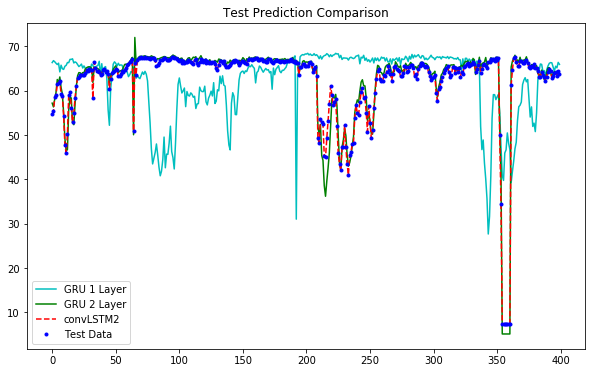

In [93]:
# Plot comparing predictions

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.figure(figsize=(10,6))

link = 4
#plt.plot(test_ups_pred0[0:300,link], 'g', label='convLSTM1')
plt.plot(test_ups_pred1[2400:2800,link], 'c', label='GRU 1 Layer')
plt.plot(test_ups_pred2[2400:2800,link], 'g', label='GRU 2 Layer')
plt.plot(test_ups_pred3[2400:2800,link], 'r--', label='convLSTM2')
plt.plot(spd_mat_upscale[30529+2400:30529+2800,link], 'b.', label='Test Data')
plt.title('Test Prediction Comparison')
plt.legend()

plt.show()


## Other experiments using subsets of data

In [0]:
# Choosing a new subset of the sensors for testing model
#from google.colab import drive
#drive.mount('/content/gdrive')

sens_sub_dt = pd.read_csv('/content/gdrive/My Drive/NNDL-data/sensor-subset-downtown.csv')
#sens_sub = pd.read_csv('data/pems-m/sensor-subset.csv')

spd_mat_dt = np.zeros([df_LA.shape[0],sens_sub_dt.shape[0]])
for i in range(sens_sub_dt.shape[0]):
  spd_mat_dt[:,i] = np.array(df_LA[sens_sub_dt.iloc[i]['sensor_id'].astype(int).astype(str)])

print(spd_mat_dt.shape)

spd_scaler_dt = MinMaxScaler(feature_range=(0, 1))
spd_mat_dt = spd_scaler_dt.fit_transform(spd_mat_dt)

n_out_dt = spd_dt_mat.shape[-1]

(34272, 32)


In [0]:
from sklearn.metrics import mean_squared_error

gen_tes_dt = generator_mat(spd_mat_dt,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)

test_pred_dt = model.predict_generator(gen_tes_dt, steps=test_steps,verbose=1)
test_pred_dt = spd_scaler_dt.inverse_transform(test_pred_dt)
spd_mat_dt = spd_scaler_dt.inverse_transform(spd_mat_dt)

mean_squared_error(test_pred_dt, spd_mat_dt[30529:30529+3712,])

29/29 [==============================] - 0s 5ms/step


198.01816366386743

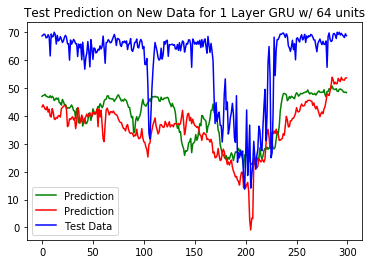

In [0]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(test_pred[0:300,30], 'g', label='Prediction')
plt.plot(test_pred_dt[0:300,30], 'r', label='Prediction')
plt.plot(spd_mat_dt[30529+0:30529+300,30], 'b', label='Test Data')
plt.title('Test Prediction on New Data for 1 Layer GRU w/ 64 units')
plt.legend()

plt.show()

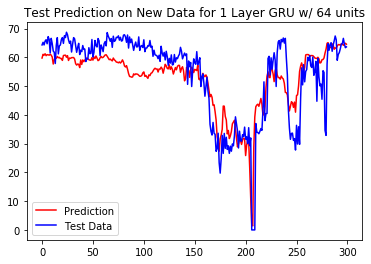

In [0]:
plt.plot(test_pred_dt[0:300,3], 'r', label='Prediction')
plt.plot(spd_mat_dt[30529+0:30529+300,3], 'b', label='Test Data')
plt.title('Test Prediction on New Data for 1 Layer GRU w/ 64 units')
plt.legend()

plt.show()